In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import skew
import statsmodels.api as sm

In [2]:
api_key = '579b464db66ec23bdd000001023b005613b940c9705454ff030f9881'
url = 'https://api.data.gov.in/resource/07d49df4-233f-4898-92db-e6855d4dd94c?api-key=579b464db66ec23bdd000001023b005613b940c9705454ff030f9881&format=json&limit=70'

response = requests.get(url).json()

In [4]:
gdp_sample_df = pd.DataFrame(columns=['Financial_year', 'GDP_in_rs_cr', 'GDP_growth_rate_yoy'])

In [5]:
for data in response['records']:
    Financial_year = data['financial_year']
    GDP_in_rs_cr = data['gross_domestic_product_in_rs_cr_at_2004_05_prices']
    GDP_growth_rate_yoy = data['gross_domestic_product___growth_rate_yoy_']
    
#     print(Financial_year)
#     print(GDP_in_rs_cr)
#     print(GDP_growth_rate_yoy)
    
    
    gdp_sample_df = gdp_sample_df.append({'Financial_year':Financial_year, 'GDP_in_rs_cr':GDP_in_rs_cr, 
                                          'GDP_growth_rate_yoy':GDP_growth_rate_yoy}, ignore_index=True)

In [6]:
gdp_sample_df.head(10)

,Financial_year,GDP_in_rs_cr,GDP_growth_rate_yoy
0,1951-52,286147,233
1,1952-53,294267,284
2,1953-54,312177,609
3,1954-55,325431,425
4,1955-56,333766,256
5,1956-57,352766,569
6,1957-58,348500,-121
7,1958-59,374948,759
8,1959-60,383153,219
9,1960-61,410279,708


In [7]:
gdp_sample_df['Financial_year'] = gdp_sample_df['Financial_year'].apply(lambda x: str(x).split('-')[0])
gdp_sample_df['Financial_year']

0     1951
1     1952
2     1953
3     1954
4     1955
      ... 
57    2008
58    2009
59    2010
60    2011
61    2012
Name: Financial_year, Length: 62, dtype: object

In [8]:
gdp_sample_df['Financial_year'] = pd.to_datetime(gdp_sample_df['Financial_year'])
gdp_sample_df['Financial_year']

0    1951-01-01
1    1952-01-01
2    1953-01-01
3    1954-01-01
4    1955-01-01
        ...    
57   2008-01-01
58   2009-01-01
59   2010-01-01
60   2011-01-01
61   2012-01-01
Name: Financial_year, Length: 62, dtype: datetime64[ns]

In [9]:
gdp_sample_df['GDP_in_rs_cr'] = gdp_sample_df['GDP_in_rs_cr'].astype('float64')
gdp_sample_df['GDP_in_rs_cr']

0      286147.0
1      294267.0
2      312177.0
3      325431.0
4      333766.0
        ...    
57    4158676.0
58    4516071.0
59    4937006.0
60    5243582.0
61    5503476.0
Name: GDP_in_rs_cr, Length: 62, dtype: float64

In [10]:
gdp_sample_df = gdp_sample_df.drop(columns=['GDP_growth_rate_yoy'])
gdp_sample_df

,Financial_year,GDP_in_rs_cr
0,1951-01-01,286147.0
1,1952-01-01,294267.0
2,1953-01-01,312177.0
3,1954-01-01,325431.0
4,1955-01-01,333766.0
...,...,...
57,2008-01-01,4158676.0
58,2009-01-01,4516071.0
59,2010-01-01,4937006.0
60,2011-01-01,5243582.0


In [11]:
gdp_sample_df1 = gdp_sample_df.set_index('Financial_year')
gdp_sample_df1

,GDP_in_rs_cr
Financial_year,
1951-01-01,286147.0
1952-01-01,294267.0
1953-01-01,312177.0
1954-01-01,325431.0
1955-01-01,333766.0
...,...
2008-01-01,4158676.0
2009-01-01,4516071.0
2010-01-01,4937006.0


### To test stationarity of our data we chose Augmented-Dickey Fuller test which will give us p-value and on that basis if greater then 0.05 then its non-stationary as in our case its non-stationary as its seen having an upward trend.

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
def adfuller_test2(x):
    result = adfuller(x)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1] <=0.05:
        print('strong evidence against null hypothesis, we will reject null hypothesis indicating it is stationary')
    else:
        print('due to weak evidence or lack of evidence against null hypothesis, we fail to reject null hypothesis indicating it is non-staionary')

In [14]:
adfuller_test2(gdp_sample_df1['GDP_in_rs_cr'])

ADF Test Statistic : 1.5552297745511696
p-value : 0.9977168474627248
#Lags Used : 11
Number of Observations Used : 50
due to weak evidence or lack of evidence against null hypothesis, we fail to reject null hypothesis indicating it is non-staionary


### So to make our data stationary i.e to remove trend we need to differentiate it once or max twice not greater then twice, if data is becoming stationary after differentiating once i.e p-value is coming less then 0.05 then our d is 1, if not then consider d = 2, we can do this by either creating a dataframe of 1 or 2 row differenced values OR by simply using ndiffs function which will give us directly the value of d and then we can put that differenced values in pacf and acf plots to get AR and MA values respectively

In [15]:
from pmdarima.arima.utils import ndiffs

In [16]:
ndiffs(gdp_sample_df1['GDP_in_rs_cr'], test='adf')

2

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Here to get our p value for auto regression we will see at what point does graph cuts significance line, it cuts negatively at 1 and positively at 11 so p = 1 or p = 11 both are fine

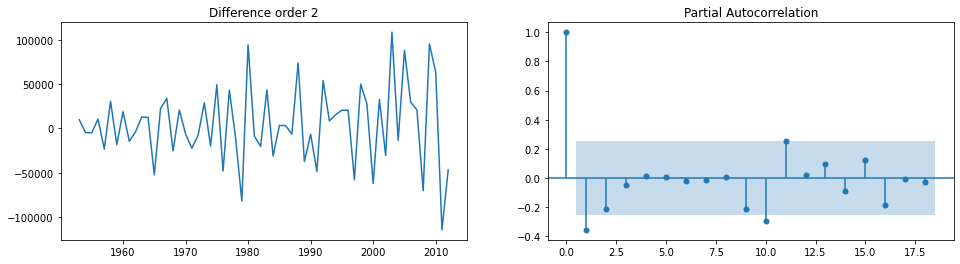

In [18]:
# To find AR(p) value

diff = gdp_sample_df1['GDP_in_rs_cr'].diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title('Difference order 2')
#ax2.set_ylim(0,1)
plot_pacf(diff, ax=ax2);

### Here to get our q value for moving averages we will see at what point does graph cuts significance line, it cuts negatively at 1 and positively at 11 so q = 1 or q = 11 both are fine

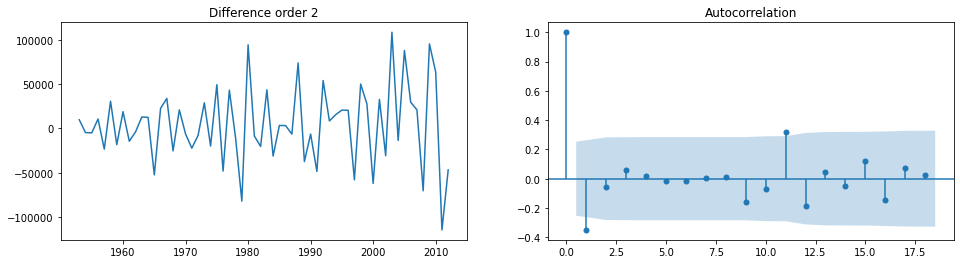

In [19]:
# To find MA(q) value

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title('Difference order 2')
#ax2.set_ylim(0,1)
plot_acf(diff, ax=ax2);

In [31]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

### Now here we will test with rmse metric how good our model is

In [32]:
## we split into train and test, 10 rows in test set and remaining in train set

print(gdp_sample_df1.shape)
train = gdp_sample_df1.iloc[:-10]
test = gdp_sample_df1.iloc[-10:]
print(train.shape, test.shape)
print(len(train))

(62, 1)
(52, 1) (10, 1)
52


In [33]:
## Now we will fit our model on train set

train_model = ARIMA(train['GDP_in_rs_cr'], order=(1,2,1))
train_model = train_model.fit()

In [34]:
## and now predict on test set

start_train = len(train)
end_train = len(train)+len(test)-1
p = train_model.predict(start=start_train, end=end_train, typ='levels')
print(p)

2003-01-01    2.695474e+06
2004-01-01    2.818887e+06
2005-01-01    2.945126e+06
2006-01-01    3.073550e+06
2007-01-01    3.204259e+06
2008-01-01    3.337236e+06
2009-01-01    3.472485e+06
2010-01-01    3.610004e+06
2011-01-01    3.749793e+06
2012-01-01    3.891853e+06
Freq: AS-JAN, dtype: float64


<AxesSubplot:xlabel='Financial_year'>

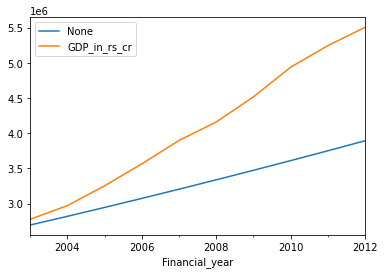

In [35]:
p.plot(legend=True)
test['GDP_in_rs_cr'].plot(legend=True)

### So below we got rmse 959097 which is pretty far from the mean of our test set i.e huge gap between rmse and test mean, so we conclude that our model is fitting well and we can predict for future predictions

In [36]:
test['GDP_in_rs_cr'].mean()

4082216.1

In [37]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(p,test['GDP_in_rs_cr']))
print(rmse)

959097.4387139055


## Now below we will fit our data on whole dataset

#### Now below from summary we can see our AIC value is pretty low for our p,q values

In [38]:
model_df = ARIMA(gdp_sample_df1['GDP_in_rs_cr'], order=(1,2,1)) #11,2,11 is also valid
result = model_df.fit()
result.summary()
#gdp_sample_df1.tail()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D2.GDP_in_rs_cr   No. Observations:                   60
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -720.692
Method:                       css-mle   S.D. of innovations          39750.869
Date:                Sun, 09 Oct 2022   AIC                           1449.383
Time:                        20:05:38   BIC                           1457.761
Sample:                    01-01-1953   HQIC                          1452.660
                         - 01-01-2012                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4967.4234   2673.667      1.858      0.063    -272.868    1.02e+04
ar.L1.D2.GDP_in_rs_cr     0.0320      0.246      0.130      0.897      -0.451       0.515
ma.L1.D2.GDP_in_rs_cr    -0.5060      0.206     -2.455      0.014      -0.910      -0.102
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           31.2761           +0.0000j           31.2761            0.0000
MA.1            1.9762           +0.0000j            1.9762            0.0000
-----------------------------------------------------------------------------
"""

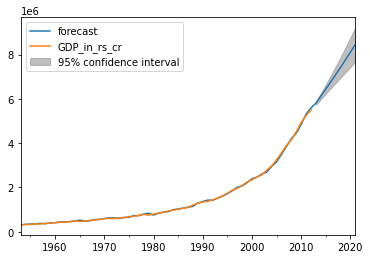

In [39]:
result.plot_predict(start=2,end=70,dynamic=False);

### Now we will predict for future predictions

In [40]:
pred = result.predict(start=len(gdp_sample_df1), end=len(gdp_sample_df1)+10, typ='levels').rename('ARIMA predictions')
print(pred)

2013-01-01    5.810288e+06
2014-01-01    6.123409e+06
2015-01-01    6.441541e+06
2016-01-01    6.764641e+06
2017-01-01    7.092709e+06
2018-01-01    7.425744e+06
2019-01-01    7.763746e+06
2020-01-01    8.106716e+06
2021-01-01    8.454653e+06
2022-01-01    8.807558e+06
2023-01-01    9.165430e+06
Freq: AS-JAN, Name: ARIMA predictions, dtype: float64


<AxesSubplot:>

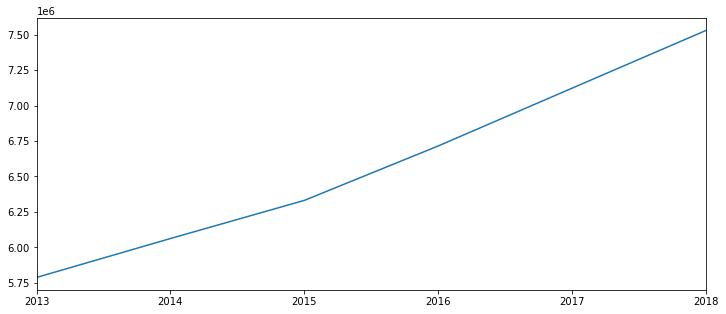

In [24]:
pred.plot(figsize=(12,5))

In [25]:
step = 2

fc, se, conf = result.forecast(step)

In [26]:
fc, conf

(array([5787645.09344653, 6057989.14745183]),
 array([[5735332.87550264, 5839957.31139042],
        [5958455.83162768, 6157522.46327599]]))

In [27]:
fc = pd.Series(pred)
lower = pd.Series(conf[:,0])
upper = pd.Series(conf[:,1])
fc

2013-01-01    5.787645e+06
2014-01-01    6.062218e+06
2015-01-01    6.331146e+06
2016-01-01    6.715119e+06
2017-01-01    7.122781e+06
2018-01-01    7.529916e+06
Freq: AS-JAN, Name: ARIMA predictions, dtype: float64

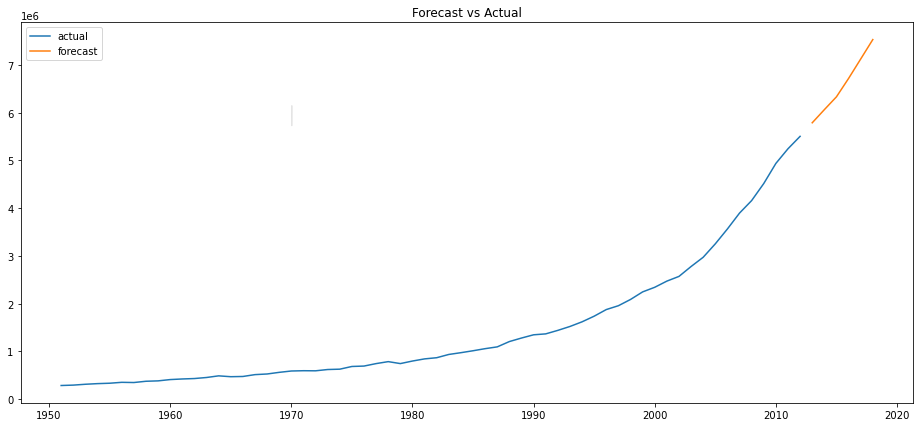

In [28]:
plt.figure(figsize=(16,7))
plt.plot(gdp_sample_df1, label='actual')
plt.plot(fc, label='forecast')
plt.fill_between(lower.index, lower, upper, color='k', alpha=0.1)
plt.title('Forecast vs Actual')
plt.legend(loc='upper left')